# 전처리 및 EDA

In [8]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
#Load Data
origin_data = pd.read_csv('./Movie_dataset/tmdb_5000_movies.csv')

In [3]:
origin_data.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [6]:
origin_data.shape

(4803, 20)

In [9]:
pr = origin_data.profile_report()

In [10]:
pr.to_file('./pr_report.html')

In [13]:
# 사용할 컬럼만 가져오기
use_col_lst = ['id','genres','vote_average','vote_count','popularity','title',
                   'keywords','overview']
data = origin_data[use_col_lst]

In [24]:
data['vote_average'].describe()

count    4803.000000
mean        6.092172
std         1.194612
min         0.000000
25%         5.600000
50%         6.200000
75%         6.800000
max        10.000000
Name: vote_average, dtype: float64

<AxesSubplot:xlabel='vote_average', ylabel='Count'>

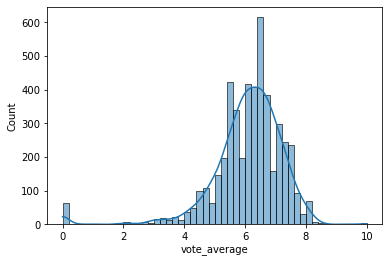

In [36]:
sns.histplot(data['vote_average'], kde = True, bins = 50)

In [63]:
#평점 개수 기준 상위 500개만 가지고 추천
vote_count_data = data['vote_count'].sort_values(ascending=False).reset_index()
m = vote_count_data.loc[499,'vote_count']
m

1778

In [64]:
top_n_data = data.query("vote_count >= @m")

In [66]:
C = top_n_data['vote_average'].mean()

6.952694610778442

In [70]:
def weighted_rating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    
    return ( v / (v+m) * R) + (m / (m + v) * C)

In [77]:
top_n_data['score'] = top_n_data.apply(weighted_rating, args=(m,C), axis = 1)

<ipython-input-77-9301b59ec0b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n_data['score'] = top_n_data.apply(weighted_rating, args=(m,C), axis = 1)


In [78]:
top_n_data.head()

,id,genres,vote_average,vote_count,popularity,title,keywords,overview,score
0,19995,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",7.2,11800,150.437577,Avatar,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","In the 22nd century, a paraplegic Marine is di...",7.167616
1,285,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",6.9,4500,139.082615,Pirates of the Caribbean: At World's End,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","Captain Barbossa, long believed to be dead, ha...",6.914924
2,206647,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.3,4466,107.376788,Spectre,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A cryptic message from Bond’s past sends him o...,6.485857
3,49026,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",7.6,9106,112.312950,The Dark Knight Rises,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",Following the death of District Attorney Harve...,7.494257
4,49529,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",6.1,2124,43.926995,John Carter,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...","John Carter is a war-weary, former military ca...",6.488542


In [80]:
top_n_data.shape

(501, 9)

In [90]:
top_n_data['genres'] = top_n_data['genres'].apply(literal_eval)
top_n_data['keywords'] = top_n_data['keywords'].apply(literal_eval)

<ipython-input-90-990bd2855b09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n_data['genres'] = top_n_data['genres'].apply(literal_eval)
<ipython-input-90-990bd2855b09>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n_data['keywords'] = top_n_data['keywords'].apply(literal_eval)


In [106]:
top_n_data['genres'] = top_n_data['genres'].apply(lambda x : [d['name'] for d in x]).apply(lambda x: " ".join(x))
top_n_data['keywords'] = top_n_data['keywords'].apply(lambda x : [d['name'] for d in x]).apply(lambda x: " ".join(x))

<ipython-input-106-298750bbc4e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n_data['genres'] = top_n_data['genres'].apply(lambda x : [d['name'] for d in x]).apply(lambda x: " ".join(x))
<ipython-input-106-298750bbc4e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_n_data['keywords'] = top_n_data['keywords'].apply(lambda x : [d['name'] for d in x]).apply(lambda x: " ".join(x))


In [107]:
top_n_data.head()

,id,genres,vote_average,vote_count,popularity,title,keywords,overview,score
0,19995,Action Adventure Fantasy Science Fiction,7.2,11800,150.437577,Avatar,culture clash future space war space colony so...,"In the 22nd century, a paraplegic Marine is di...",7.167616
1,285,Adventure Fantasy Action,6.9,4500,139.082615,Pirates of the Caribbean: At World's End,ocean drug abuse exotic island east india trad...,"Captain Barbossa, long believed to be dead, ha...",6.914924
2,206647,Action Adventure Crime,6.3,4466,107.376788,Spectre,spy based on novel secret agent sequel mi6 bri...,A cryptic message from Bond’s past sends him o...,6.485857
3,49026,Action Crime Drama Thriller,7.6,9106,112.312950,The Dark Knight Rises,dc comics crime fighter terrorist secret ident...,Following the death of District Attorney Harve...,7.494257
4,49529,Action Adventure Science Fiction,6.1,2124,43.926995,John Carter,based on novel mars medallion space travel pri...,"John Carter is a war-weary, former military ca...",6.488542


In [109]:
top_n_data.to_csv('./Movie_dataset/pre_tmdb_5000_movies.csv', index = False)

# 컨텐츠 기반 필터링 추천

장르를 기반으로 추천

In [113]:
#CountVetorizer 객체 생성
count_vector = CountVectorizer(ngram_range=(1,3))

In [116]:
c_vector_genres = count_vector.fit_transform(top_n_data['genres'])

In [197]:
#생성된 CounterVector Matrix 확인
c_verctor_df = pd.DataFrame(c_vector_genres.toarray(), columns = sorted(count_vector.vocabulary_))
c_verctor_df.index = top_n_data['title']
c_verctor_df

,action,action adventure,action adventure animation,action adventure comedy,action adventure crime,action adventure fantasy,action adventure romance,action adventure science,action adventure thriller,action adventure war,...,thriller war,war,war action,war drama,war drama action,war history,western,western adventure,western drama,western drama adventure
title,,,,,,,,,,,,,,,,,,,,,
Avatar,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pirates of the Caribbean: At World's End,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spectre,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Dark Knight Rises,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
John Carter,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Reservoir Dogs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"The Good, the Bad and the Ugly",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Rocky,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


코사인 유사도 계산

In [153]:
genre_c_sim = cosine_similarity(c_vector_genres, c_vector_genres).argsort()[:, ::-1]
genre_c_sim

array([[  0,  13,  42, ..., 390, 391, 500],
       [  1, 152, 146, ..., 429, 283, 500],
       [  2, 389, 368, ..., 249, 248, 500],
       ...,
       [500, 488, 335, ..., 278, 282,   0],
       [483, 499, 194, ..., 254, 256,   0],
       [500, 488, 335, ..., 278, 282,   0]], dtype=int64)

영화를 입력하면 해당 영화 장르와 가장 유사한 상위 30개 영화 추천해주는 함수

In [180]:
def get_recommend_movie_list(df, genre_c_sim, movie_title, top=30):
    
    target_movie_index = df.query("title == @movie_title").index.values.astype(int)[0]
    
    sim_index = genre_c_sim[target_movie_index, :top].reshape(-1)
    
    sim_index = sim_index[sim_index != target_movie_index]
    
    result = df.iloc[sim_index].sort_values('score', ascending=False)[:10]
    return result

결과 확인

The Dark Knight Rises의 장르와 가장 유사한 영화는 The Dark Knight

In [181]:
get_recommend_movie_list(top_n_data, genre_c_sim, movie_title='The Dark Knight Rises')

,id,genres,vote_average,vote_count,popularity,title,keywords,overview,score
65,155,Drama Action Crime Thriller,8.2,12002,187.322927,The Dark Knight,dc comics crime fighter secret identity scarec...,Batman raises the stakes in his war on crime. ...,8.039063
2091,274,Crime Drama Thriller,8.1,4443,18.174804,The Silence of the Lambs,based on novel psychopath horror suspense seri...,"FBI trainee, Clarice Starling ventures into a ...",7.772093
2760,264644,Drama Thriller,8.1,2757,66.113340,Room,based on novel carpet isolation kidnapping imp...,Jack is a young boy of 5 years old who has liv...,7.650185
351,1422,Drama Thriller Crime,7.9,4339,63.429157,The Departed,undercover boston police friends mafia underco...,"To take down South Boston's Irish Mafia, the p...",7.624651
1850,111,Action Crime Drama Thriller,8.0,2948,70.105981,Scarface,miami corruption capitalism cuba prohibition b...,After getting a green card in exchange for ass...,7.605986
4337,103,Crime Drama,8.0,2535,58.845025,Taxi Driver,vietnam veteran taxi obsession drug dealer nig...,A mentally unstable Vietnam War veteran works ...,7.568257
1051,146233,Drama Thriller Crime,7.9,3085,88.496873,Prisoners,pennsylvania kidnapping maze vigilante rural s...,When Keller Dover's daughter and her friend go...,7.553648
828,24,Action Crime,7.7,4949,79.754966,Kill Bill: Vol. 1,japan coma martial arts kung fu underworld yak...,An assassin is shot at the altar by her ruthle...,7.502481
3701,641,Crime Drama,7.9,2443,11.573034,Requiem for a Dream,drug addiction junkie heroin speed diet unsoci...,The hopes and dreams of four ambitious people ...,7.500969
1829,6977,Crime Drama Thriller,7.7,3003,53.645267,No Country for Old Men,texas drug traffic hitman united states–mexico...,"Llewelyn Moss stumbles upon dead bodies, $2 mi...",7.422086
